<a href="https://colab.research.google.com/github/fastdatascience/clinical_trial_risk/blob/fixes_nov_2022/TrainNumCountriesClassifier_13_Naive_Bayes_bigrams_200_feat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df_annotations = pd.read_csv("/content/drive/MyDrive/data/all_annotations.csv")


# Get data

In [6]:
with open("/content/drive/MyDrive/data/protocols.pkl.gz", "rb") as f:
    file_to_pages = pkl.load(f)

In [7]:
texts = []

for i in range(len(df_annotations)):
    file_name = df_annotations.file.iloc[i]
    
    pages= file_to_pages[file_name]
    # Limit to first 3 pages because of memory constraints
    if len(pages) > 30:
      pages = pages[:30]

    texts.append(" ".join(pages))
df_annotations["text"] = texts

In [8]:
def get_num_countries(x):
  if x is not None and type(x) is str:
    return len(x.split(","))
  return None

In [9]:
df_annotations["num_countries"] = df_annotations.country.apply(get_num_countries)

In [10]:
df_annotations["num_countries"].value_counts()

1.0     7998
2.0      726
3.0      341
4.0      263
5.0      230
6.0      225
7.0      193
8.0      176
10.0     155
9.0      137
11.0     135
12.0     116
13.0     109
14.0      92
15.0      90
17.0      78
18.0      68
16.0      65
21.0      57
20.0      56
19.0      54
23.0      47
22.0      44
24.0      35
25.0      31
26.0      27
29.0      22
30.0      21
27.0      20
31.0      19
28.0      18
32.0      17
33.0      14
41.0      11
34.0      11
38.0       8
39.0       8
37.0       7
43.0       7
36.0       6
35.0       6
44.0       6
40.0       6
48.0       6
47.0       3
42.0       2
49.0       2
50.0       2
45.0       1
58.0       1
46.0       1
62.0       1
51.0       1
54.0       1
Name: num_countries, dtype: int64

In [11]:
def get_is_international(num):
    if num is None or pd.isna(num):
      return None
    if num >= 2:
      return 1
    return 0
df_annotations["is_international"] = df_annotations["num_countries"].apply(get_is_international)

In [12]:
df_annotations["is_international"].value_counts()

0.0    7998
1.0    3778
Name: is_international, dtype: int64

# Train and evaluate the number of countries extractor

In [13]:
df_train = df_annotations[(df_annotations.train_val == "train") & (~df_annotations.is_international.isna())]

In [14]:
df_train_to_augment = df_train[df_train.is_international == 1]

In [15]:
df_train_augmented = df_train # pd.concat([df_train, df_train_to_augment])

In [16]:
df_train_augmented["is_international"].value_counts()

0.0    6375
1.0    3052
Name: is_international, dtype: int64

In [17]:
df_val = df_annotations[df_annotations.train_val == "val"]

In [18]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import make_pipeline

In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [29]:
NUM_FEATURES = 200

stops = set(stopwords.words('english')).union(set(stopwords.words('french')))
stops.remove("both")
stops.remove("all")
# stops  = set()

# Specially engineered regex to include 95%, 95%ci, etc
vectoriser = CountVectorizer(lowercase=True, stop_words=stops, min_df=5, max_features=NUM_FEATURES,
                             token_pattern=r'[a-z][a-z]+', ngram_range=[1,2])
transformer = TfidfTransformer()

nb = BernoulliNB()
model = make_pipeline(vectoriser, transformer, nb)

In [30]:
model.fit(df_train_augmented.text, df_train_augmented.is_international)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['taient', 'tais', 'tait', 'tant', 'tante', 'tantes', 'tants', 'tiez', 'tions'] not in stop_words.
  % sorted(inconsistent)


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=200, min_df=5, ngram_range=[1, 2],
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ai', 'aie',
                                             'aient', 'aies', 'ain', 'ait',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'au',
                                             'aura', 'aurai', 'auraient',
                                             'aurais', 'aurait', 'auras',
                                             'aurez', 'auriez', ...},
                                 token_pattern='[a-z][a-z]+')),
                ('tfidftransformer', TfidfTransformer()),
                ('bernoullinb', BernoulliNB())])

In [31]:
df_val["pred_international"] = model.predict(df_val.text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
pred_international = df_val["pred_international"]

In [33]:
is_international_ground_truths = df_val.is_international

In [34]:
acc = accuracy_score(is_international_ground_truths.apply(str), pred_international.apply(str))
print (f"Num countries accuracy {acc}")

Num countries accuracy 0.680184331797235


''

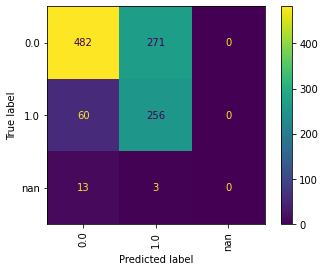

In [35]:
ConfusionMatrixDisplay.from_predictions(is_international_ground_truths.apply(str), pred_international.apply(str))
plt.xticks(rotation=90)
;

In [27]:
fake_document = " ".join(vectoriser.vocabulary_)
vectorised_document = vectoriser.transform([fake_document])
transformed_document = transformer.transform(vectorised_document)
probas = np.zeros((transformed_document.shape[1]))

for prediction_idx in range(2):
    print(f"Strongest predictors for class {prediction_idx}\n")
    for i in range(transformed_document.shape[1]):
        zeros = np.zeros(transformed_document.shape)
        zeros[0, i] = transformed_document[0, i]
        proba = nb.predict_log_proba(zeros)
        probas[i] = proba[0, prediction_idx]

    for ctr, j in enumerate(np.argsort(-probas)):
        for w, i in vectoriser.vocabulary_.items():
            if i == j:
                print(f"{ctr}\t{w}")
        if ctr > 25:
          break

Strongest predictors for class 0

0	abbreviations
1	post treatment
2	post
3	possible
4	positive
5	populations
6	population
7	points
8	point
9	po
10	plus
11	pli
12	please
13	platelet
14	plasma
15	planned
16	plan
17	placebo controlled
18	placebo
19	place
20	potential
21	pl
22	potentially
23	pp
24	previously
25	previous
26	prevention
Strongest predictors for class 1

0	eudract
1	ethics committee
2	abbreviations
3	iec
4	tables
5	ethics
6	amendment
7	table contents
8	european
9	committee
10	protocol amendment
11	contents
12	concomitant
13	pk
14	ecrf
15	assessments
16	primary efficacy
17	confidential
18	electrocardiogram
19	change baseline
20	pharmacokinetic
21	list
22	synopsis
23	ecg
24	handling
25	screening period
26	phase


In [28]:
import bz2

with bz2.open("/content/drive/MyDrive/data/is_international_classifier.pkl.bz2", "wb") as f:
    pkl.dump(model, f)